In [29]:
import numpy as np
import torch
from torch import optim
import os
import sys
sys.path.append('C:\\Users\\chris\\Desktop\\Masterarbeit\\code')
from utils.dataloader import get_data_loader
from networks.cnn import CNN, CNN_pool
import matplotlib.pyplot as plt
import pyreadr

# Results from all image fit PL

In [3]:
exp = "exp_3"
path = f'../data/{exp}/data/'
brown_params = np.unique(pyreadr.read_r(path+"brown_test_params.RData")["test_params"].to_numpy(), axis = 0)
brown_params = brown_params[brown_params[:, 1].argsort()]
schlather_params = np.unique(pyreadr.read_r(path+"powexp_test_params.RData")["test_params"].to_numpy(), axis = 0)
schlather_params = schlather_params[schlather_params[:, 1].argsort()]

In [14]:
path = f'../data/{exp}/results/'
brown_all_img = pyreadr.read_r(path+"brown_fit_all_images.RData")["res"].to_numpy()
schlather_all_img = pyreadr.read_r(path+"schlather_fit_all_images.RData")["res"].to_numpy()[:,1:]

In [15]:
#Brown results
res = brown_params-brown_all_img
rmse = np.sqrt(np.mean(np.power(res,2), axis = 0))
mae = np.mean(np.abs(res), axis = 0)
print(rmse)
print(mae)

[0.01901122 0.02658438]
[0.01298615 0.01999555]


In [16]:
#Schlather results
res = schlather_params-schlather_all_img
rmse = np.sqrt(np.mean(np.power(res,2), axis = 0))
mae = np.mean(np.abs(res), axis = 0)
print(rmse)
print(mae)

[4.3701001  0.53205435]
[2.19870579 0.45332896]


# Result from one image fit PL

In [17]:
path = f'../data/{exp}/data/'
brown_params = pyreadr.read_r(path+"brown_test_params.RData")["test_params"].to_numpy()
schlather_params = pyreadr.read_r(path+"schlather_test_params.RData")["test_params"].to_numpy()
path = f'../data/{exp}/results/'
brown_res = pyreadr.read_r(path+"brown_single_image_fit.RData")["results"].to_numpy()
schlather_res = pyreadr.read_r(path+"schlather_single_image_fit.RData")["results"].to_numpy()[:,1:]

In [18]:
#Brown results
res = brown_params-brown_res
rmse = np.sqrt(np.mean(np.power(res,2), axis = 0))
mae = np.mean(np.abs(res), axis = 0)
print(np.round(rmse,2))
print(np.round(mae,2))

[0.21 0.23]
[0.11 0.18]


In [19]:
#Schlather results
res = schlather_params-schlather_res
rmse = np.sqrt(np.mean(np.power(res,2), axis = 0))
mae = np.mean(np.abs(res), axis = 0)
print(np.round(rmse,2))
print(np.round(mae,2))

[0.52 0.68]
[0.41 0.57]


## Results from image fit with wide starting range

In [20]:
path = f'../data/{exp}/results/'
brown_res = pyreadr.read_r(path+"brown_single_image_fit_wide.RData")["results"].to_numpy()
schlather_res = pyreadr.read_r(path+"schlather_single_image_fit_wide.RData")["results"].to_numpy()[:,1:]

In [21]:
#Brown results
res = brown_params-brown_res
rmse = np.sqrt(np.mean(np.power(res,2), axis = 0))
mae = np.mean(np.abs(res), axis = 0)
print(np.round(rmse,2))
print(np.round(mae,2))

[0.38 0.38]
[0.19 0.25]


In [22]:
#Schlather results
res = schlather_params-schlather_res
rmse = np.sqrt(np.mean(np.power(res,2), axis = 0))
mae = np.mean(np.abs(res), axis = 0)
print(np.round(rmse,2))
print(np.round(mae,2))

[1.14 0.48]
[0.93 0.4 ]


## Results from optimized one-image fit

In [35]:
exp = "exp_3"
path = f'../data/{exp}/data/'
brown_params = pyreadr.read_r(path+"brown_test_params.RData")["test_params"].to_numpy()
schlather_params = pyreadr.read_r(path+"powexp_test_params.RData")["test_params"].to_numpy()
path = f'../data/{exp}/results/'
brown_res = pyreadr.read_r(path+"brown_single_image_fit_opt.RData")["results"].to_numpy()
schlather_res = pyreadr.read_r(path+"powexp_single_image_fit_opt.RData")["results"].to_numpy()[:,1:]

In [36]:
#Brown results
res = brown_params-brown_res
rmse = np.sqrt(np.mean(np.power(res,2), axis = 0))
mae = np.mean(np.abs(res), axis = 0)
print(np.round(rmse,2))
print(np.round(mae,2))
print(np.round(np.mean(res, axis = 0),2))

[5.69095e+03 6.90000e-01]
[6.199e+02 4.300e-01]
[-6.1966e+02  3.3000e-01]


In [32]:
#Schlather results
res = schlather_params-schlather_res
rmse = np.sqrt(np.mean(np.power(res,2), axis = 0))
mae = np.mean(np.abs(res), axis = 0)
print(np.round(rmse,2))
print(np.round(mae,2))
print(np.round(np.mean(res, axis = 0),2))

[1.78 0.86]
[1.55 0.68]
[1.5  0.47]


IndexError: index 755 is out of bounds for axis 0 with size 750

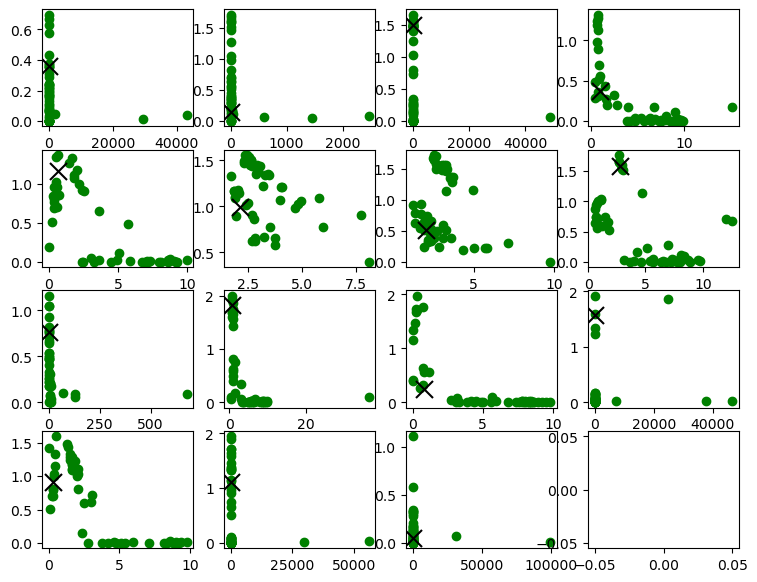

In [34]:
#Results brown
pred = brown_res
param = brown_params
n_comb = 25
fig, axs = plt.subplots(4,4,figsize = (9,7))
axs = axs.ravel()
for i in range(n_comb):
    axs[i].scatter(x = pred[(i*50):((i+1)*50),0], y = pred[(i*50):((i+1)*50),1], color = "green")
    axs[i].scatter(x = param[5+(i*50),0], y = param[5+(i*50),1], color = "black", marker = "x", s = 150)
    #axs[i].scatter(x = brown_all_img[i,0], y = brown_all_img[i,1], color = "red", marker = "+", s = 150)
    #axs[i].set_xlim([0,2.5])
    #axs[i].set_ylim([0,2])
    
   # if i < 12:
   #     axs[i].get_xaxis().set_visible(False)
   # if (i%4) != 0:
   #     axs[i].get_yaxis().set_visible(False)  
        
fig.tight_layout()

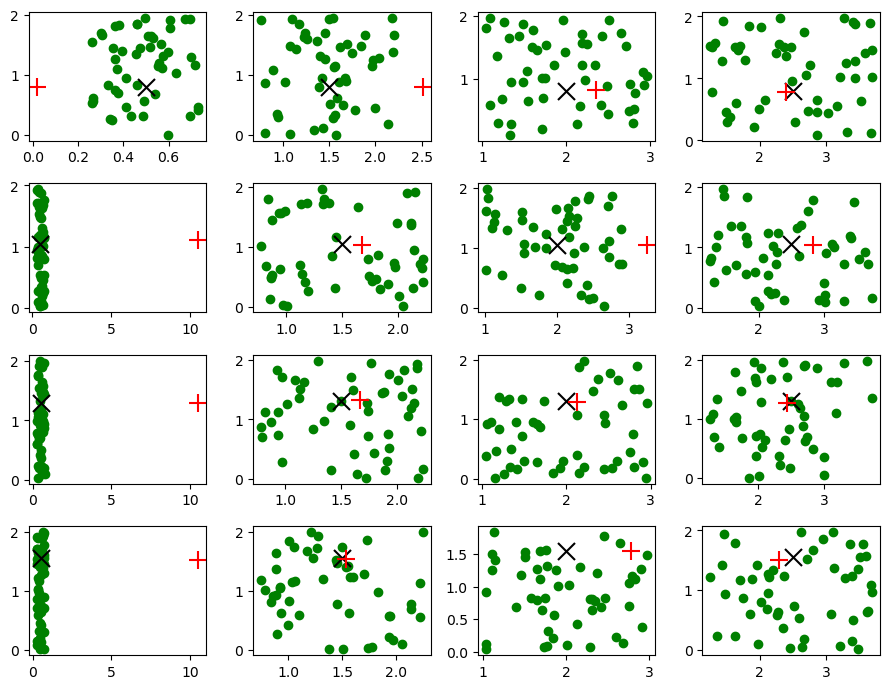

In [27]:
#Results Schlather
pred = schlather_res
param = schlather_params
n_comb = 16
fig, axs = plt.subplots(4,4,figsize = (9,7))
axs = axs.ravel()
for i in range(n_comb):
    axs[i].scatter(x = pred[(i*50):((i+1)*50),0], y = pred[(i*50):((i+1)*50),1], color = "green")
    axs[i].scatter(x = param[5+(i*50),0], y = param[5+(i*50),1], color = "black", marker = "x", s = 150)
    axs[i].scatter(x = schlather_all_img[i,0], y = brown_all_img[i,1], color = "red", marker = "+", s = 150)
    #axs[i].set_xlim([0,4])
    #axs[i].set_ylim([-0.5,2.4])
    
  #  if i < 12:
  #      axs[i].get_xaxis().set_visible(False)
  #  if (i%4) != 0:
  #      axs[i].get_yaxis().set_visible(False)  
        
fig.tight_layout()

# Results CNN Brown

In [37]:
# Dataloader
exp = "exp_3"
path = f"../data/{exp}/data/"
model = "brown"
dataloader, dataset = get_data_loader(data_path = path, model = model, batch_size=800, var = "test")

In [39]:
#Load model
net = CNN_pool()
net.load_state_dict(torch.load(f"../data/{exp}/checkpoints/cnn_{model}.pt"))
net.eval()

CNN_pool(
  (conv_input): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv_64): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv_128): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv_128_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv_256): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv_256_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_1): Linear(in_features=2304, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=2, bias=True)
  (output_1): Linear(in_features=256, out_features=1, bias=True)
  (output_2): Linear(in_features=256, out_features=1, bias=True)
)

In [40]:
for sample in dataloader:
    img, param = sample
    break 
pred = net(img).detach().numpy()
param = param.detach().numpy()

# Calculate metrics

In [41]:
def retransform(params):
    result = np.zeros(shape = params.shape)
    result[:,0] = np.exp(params[:,0])
    result[:,1] = (2*np.exp(params[:,1]))/(1+np.exp(params[:,1]))
    return result    

In [42]:
def retransform2(params):
    result = np.zeros(shape = params.shape)
    #result[:,0] = params[:,0]*(3-0.1)+0.1
    result[:,0] = np.exp(params[:,0])
    result[:,1] = params[:,1]*2
    return result  

In [43]:
pred_tf = retransform2(pred)
param_tf = np.round(retransform2(param),3)

In [44]:
param_tf

array([[1.993, 0.359],
       [1.993, 0.359],
       [1.993, 0.359],
       ...,
       [0.307, 0.163],
       [0.307, 0.163],
       [0.307, 0.163]])

In [45]:
rmse = np.sqrt(np.mean((np.power(pred_tf-param_tf,2)), axis = 0))
mae = np.mean(np.abs(pred_tf-param_tf), axis = 0)
bias = np.mean(pred_tf-param_tf, axis = 0)
print(f"RMSE: {np.round(rmse,2)}")
print(f"MAE: {np.round(mae,2)}")
print(f"Bias: {np.round(bias,2)}")

RMSE: [0.8  0.29]
MAE: [0.58 0.22]
Bias: [0.34 0.04]


In [ ]:
n_comb = 16
fig, axs = plt.subplots(4,4,figsize = (9,7))
axs = axs.ravel()
for i in range(n_comb):
    axs[i].scatter(x = pred_tf[(i*50):((i+1)*50),0], y = pred_tf[(i*50):((i+1)*50),1], color = "green")
    axs[i].scatter(x = param_tf[5+(i*50),0], y = param_tf[5+(i*50),1], color = "black", marker = "x", s = 150)
    axs[i].set_xlim([0.2,3])
    axs[i].set_ylim([0.2,2.5])
    
    if i < 12:
        axs[i].get_xaxis().set_visible(False)
    if (i%4) != 0:
        axs[i].get_yaxis().set_visible(False)  
        
fig.tight_layout()

#plt.savefig(plot_path+"metrics_scatter_convergence.png", dpi = 300, bbox_inches = "tight")

IndexError: index 755 is out of bounds for axis 0 with size 750

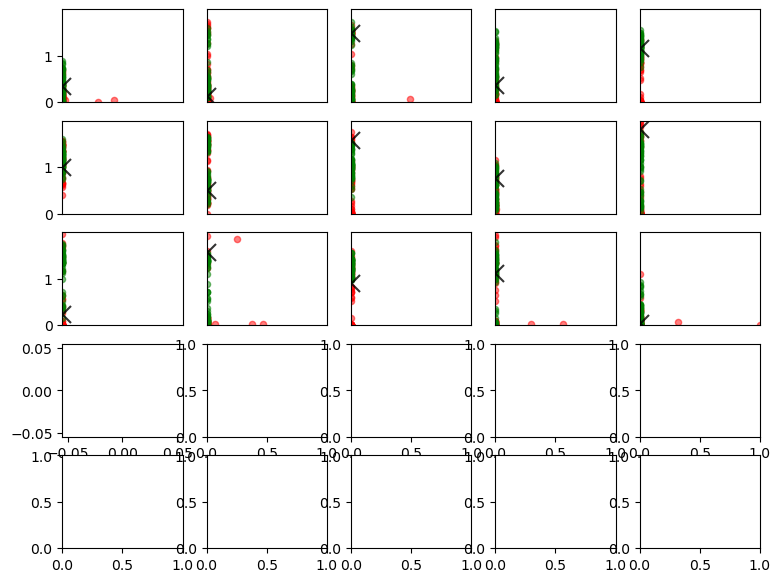

In [46]:
# With Likelihood fixed range
range_1 = max(brown_res[:,0].max(),pred_tf[:,0].max())
range_2 = max(brown_res[:,1].max(),pred_tf[:,1].max())
n_comb = 25
fig, axs = plt.subplots(5,5,figsize = (9,7))
axs = axs.ravel()
for i in range(n_comb):
    axs[i].scatter(x = brown_res[(i*50):((i+1)*50),0], y = brown_res[(i*50):((i+1)*50),1], color = "red", s = 20, alpha = 0.5)
    axs[i].scatter(x = pred_tf[(i*50):((i+1)*50),0], y = pred_tf[(i*50):((i+1)*50),1], color = "green", s = 20, alpha = 0.5)
    axs[i].scatter(x = param_tf[5+(i*50),0], y = param_tf[5+(i*50),1], color = "black", marker = "x", s = 150, alpha = 0.8)    
    axs[i].set_xlim([0,range_1])
    axs[i].set_ylim([0,range_2])
    
    if i < 20:
        axs[i].get_xaxis().set_visible(False)
    if (i%5) != 0:
        axs[i].get_yaxis().set_visible(False)  
        
fig.tight_layout()

#plt.savefig(plot_path+"metrics_scatter_convergence.png", dpi = 300, bbox_inches = "tight")

In [ ]:
# With Likelihood flexible range
n_comb = 16
fig, axs = plt.subplots(4,4,figsize = (9,7))
axs = axs.ravel()
for i in range(n_comb):
    axs[i].scatter(x = brown_res[(i*50):((i+1)*50),0], y = brown_res[(i*50):((i+1)*50),1], color = "red", s = 20, alpha = 0.5)
    axs[i].scatter(x = pred_tf[(i*50):((i+1)*50),0], y = pred_tf[(i*50):((i+1)*50),1], color = "green", s = 20, alpha = 0.5)
    axs[i].scatter(x = param_tf[5+(i*50),0], y = param_tf[5+(i*50),1], color = "black", marker = "x", s = 150, alpha = 0.8)    
        
fig.tight_layout()

#plt.savefig(plot_path+"metrics_scatter_convergence.png", dpi = 300, bbox_inches = "tight")

# Results CNN Schlather

In [38]:
# Dataloader
exp = "exp_2"
path = f"../data/{exp}/data/"
model = "schlather"
dataloader, dataset = get_data_loader(data_path = path, model = model, batch_size=800, var = "test")

In [39]:
#Load model
net = CNN_pool()
net.load_state_dict(torch.load(f"../data/exp_2/checkpoints/cnn_pool_{model}.pt"))
net.eval()

CNN_pool(
  (conv_input): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv_64): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv_128): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv_128_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv_256): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv_256_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_1): Linear(in_features=2304, out_features=256, bias=True)
  (output): Linear(in_features=256, out_features=2, bias=True)
  (output_1): Linear(in_features=256, out_features=1, bias=True)
  (output_2): Linear(in_features=256, out_features=1, bias=True)
)

In [40]:
for sample in dataloader:
    img, param = sample
    break 
pred = net(img).detach().numpy()
param = param.detach().numpy()

# Calculate metrics

In [41]:
pred_tf = retransform2(pred)
param_tf = np.round(retransform2(param),3)

In [42]:
rmse = np.sqrt(np.mean((np.power(pred_tf-param_tf,2)), axis = 0))
mae = np.mean(np.abs(pred_tf-param_tf), axis = 0)
bias = np.mean(pred_tf-param_tf, axis = 0)
print(f"RMSE: {np.round(rmse,2)}")
print(f"MAE: {np.round(mae,2)}")
print(f"Bias: {np.round(bias,2)}")

RMSE: [0.54 0.2 ]
MAE: [0.45 0.15]
Bias: [ 0.16 -0.03]


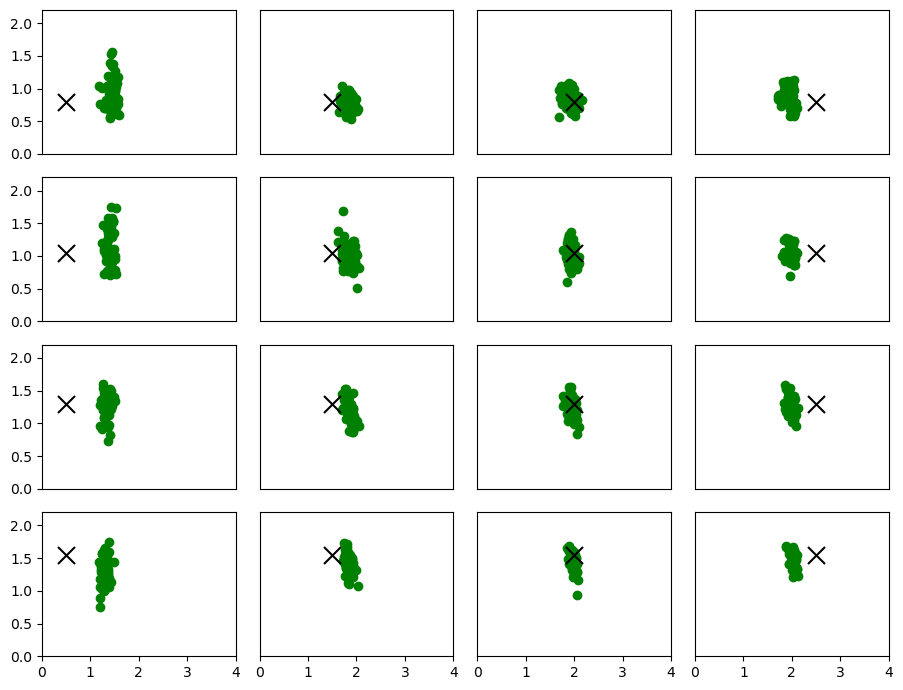

In [43]:
n_comb = 16
fig, axs = plt.subplots(4,4,figsize = (9,7))
axs = axs.ravel()
for i in range(n_comb):
    axs[i].scatter(x = pred_tf[(i*50):((i+1)*50),0], y = pred_tf[(i*50):((i+1)*50),1], color = "green")
    axs[i].scatter(x = param_tf[5+(i*50),0], y = param_tf[5+(i*50),1], color = "black", marker = "x", s = 150)
    axs[i].set_xlim([0,4])
    axs[i].set_ylim([0,2.2])
    
    if i < 12:
        axs[i].get_xaxis().set_visible(False)
    if (i%4) != 0:
        axs[i].get_yaxis().set_visible(False)  
        
fig.tight_layout()

#plt.savefig(plot_path+"metrics_scatter_convergence.png", dpi = 300, bbox_inches = "tight")

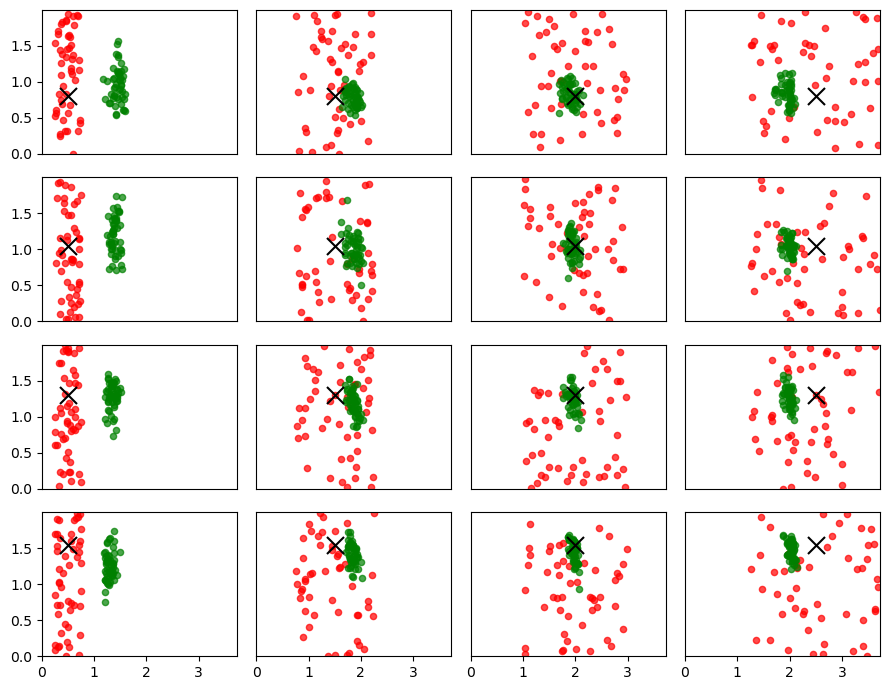

In [44]:
# With Likelihood fixed range
range_1 = max(schlather_res[:,0].max(),pred_tf[:,0].max())
range_2 = max(schlather_res[:,1].max(),pred_tf[:,1].max())
n_comb = 16
fig, axs = plt.subplots(4,4,figsize = (9,7))
axs = axs.ravel()
for i in range(n_comb):
    axs[i].scatter(x = schlather_res[(i*50):((i+1)*50),0], y = schlather_res[(i*50):((i+1)*50),1], color = "red", s = 20, alpha = 0.7)
    axs[i].scatter(x = pred_tf[(i*50):((i+1)*50),0], y = pred_tf[(i*50):((i+1)*50),1], color = "green", s = 20, alpha = 0.7)
    axs[i].scatter(x = param_tf[5+(i*50),0], y = param_tf[5+(i*50),1], color = "black", marker = "x", s = 150)    
    axs[i].set_xlim([0,range_1])
    axs[i].set_ylim([0,range_2])
    
    if i < 12:
        axs[i].get_xaxis().set_visible(False)
    if (i%4) != 0:
        axs[i].get_yaxis().set_visible(False)  
        
fig.tight_layout()

#plt.savefig(plot_path+"metrics_scatter_convergence.png", dpi = 300, bbox_inches = "tight")

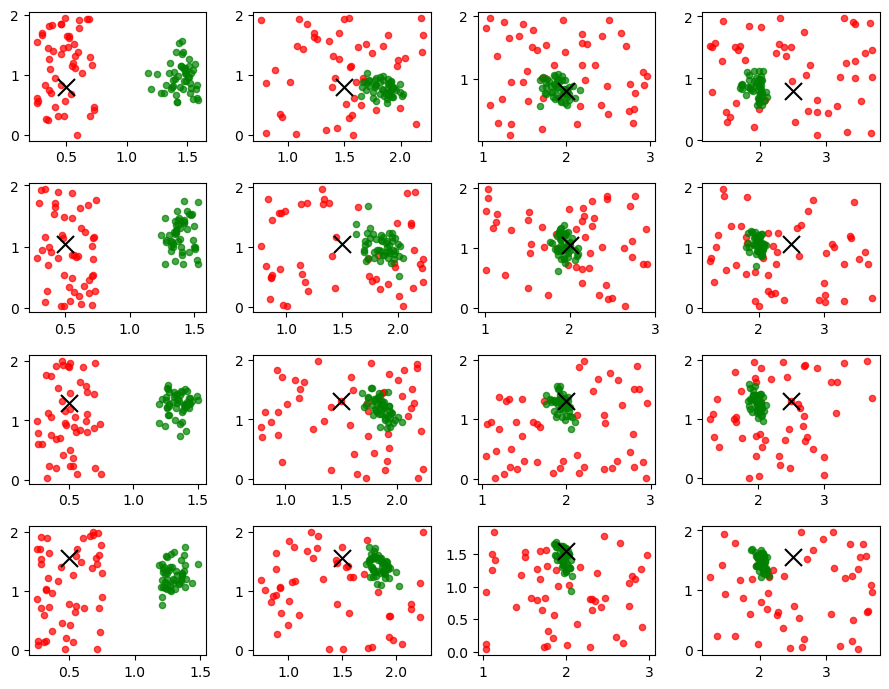

In [45]:
# With Likelihood flexible range
n_comb = 16
fig, axs = plt.subplots(4,4,figsize = (9,7))
axs = axs.ravel()
for i in range(n_comb):
    axs[i].scatter(x = schlather_res[(i*50):((i+1)*50),0], y = schlather_res[(i*50):((i+1)*50),1], color = "red", s = 20, alpha = 0.7)
    axs[i].scatter(x = pred_tf[(i*50):((i+1)*50),0], y = pred_tf[(i*50):((i+1)*50),1], color = "green", s = 20, alpha = 0.7)
    axs[i].scatter(x = param_tf[5+(i*50),0], y = param_tf[5+(i*50),1], color = "black", marker = "x", s = 150)    
        
fig.tight_layout()

#plt.savefig(plot_path+"metrics_scatter_convergence.png", dpi = 300, bbox_inches = "tight")